![cell_proportion](./images/cell_proportion.png)

## Classification

Classification is a key task as the relative proportion of the different white blood cells
categories indicates the presence or not of a pathology.

This part's goal is to leverage an open-source dataset of white blood cells in order to
train a Deep Learning model to perform classification.

In [3]:
!pip install medmnist

  Using cached medmnist-3.0.2-py3-none-any.whl.metadata (14 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scikit_image-0.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached fire-0.7.0-py3-none-any.whl
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.5.10-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached medmnist-3.0.2-py3-none-any.whl (25 kB)
Using cached scikit_image-0.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.8 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2025.5.10-py3-none-any.whl (226 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86

In [4]:
# Let's load the dataset
import medmnist
from medmnist import INFO, Evaluator, BloodMNIST

train_dataset = BloodMNIST(split="train", size=64, download=True)
val_dataset = BloodMNIST(split="val", size=64, download=True)
test_dataset = BloodMNIST(split="test", size=64, download=True)

Using downloaded and verified file: /home/guevel/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /home/guevel/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /home/guevel/.medmnist/bloodmnist_64.npz


This dataset contains images of white blood cells that are divided between 8 categories:

- basophil
- eosinophil
- erythroblast
- immature granulocytes
- lymphocyte
- monocyte
- neutrophil
- platelet

### Understand an image

Le label de l'image est : eosinophil



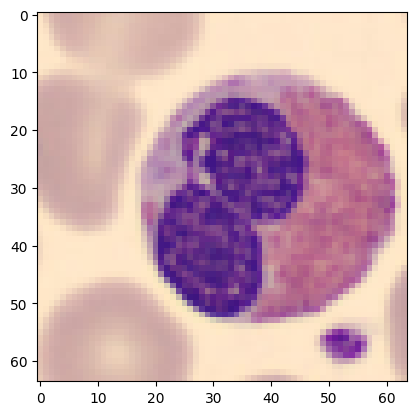

In [5]:
import random
import matplotlib.pyplot as plt

train_size = len(train_dataset)

label_dict = train_dataset.info["label"]
img, label = train_dataset[random.randint(0, train_size)]

print(f"Le label de l'image est : {label_dict.get(str(label[0]))}\n")
plt.imshow(img)
plt.show()

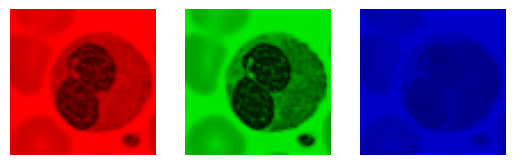

In [40]:
import numpy as np

image = np.array(img.convert("RGB"))
figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(image.shape, dtype='uint8')
    temp[:,:,i] = image[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

The first step is to create a [dataset](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)
object in order to use pytorch's functions for the training of our model.

### Create the data objects

In [4]:
# The first step is to make a dataset, for this we need to create our own custom object
from torch.utils.data import Dataset


class CustomDataset(Dataset):

    def __init__(self, data, transform):
        # initialization method
        pass

    def __len__(self):
        # should return the number of elements of the dataset
        pass

    def __getitem__(self, idx):
        # should return the element of the dataset at index idx
        pass

In [34]:
# Uncomment below and run this cell to make the solution appear
# %load ../src/custom_dataset.py

In [35]:
import torchvision.transforms as transforms

# Here we need a transform vision to convert the data which are PIL images into vectors
transform = transforms.ToTensor()

training_dataset = CustomDataset(train_dataset, transform)
validation_dataset = CustomDataset(val_dataset, transform)

Then we can make a dataloader in order to load the data by batches and accelerate
the training process

In [38]:
# Make your own dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(training_dataset, batch_size=64)
valid_loader = DataLoader(validation_dataset, batch_size=64)

### Create the model

In [17]:
# We then create a model from a pretrained point
from torchvision import models

model = models.resnet18(pretrained=True)

In [12]:
# You can also make your own model architecture!
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        # create layers here
        # self.l1 = ...

    def forward(self, x):
        # here the output should be a vector of size num_classes
        pass

In [14]:
# Uncomment below and run this cell to make the solution appear
# %load ../src/net.py

### Training loop

In [31]:
# Now we need to make an optimizer + a loss
import torch.optim as optim

# cross-entropy loss is the one used for multi classification tasks
criterion = nn.CrossEntropyLoss()

# Adam is a popular optimizer, but other could be used (SGD, Adamw...)
optimizer = optim.Adam(model.parameters())

Now we have everything necessary in order to launch the training process.  
> ToDo : Find an image to illustrate training loop

In [46]:
# %load ../src/training.py
import torch
from tqdm import tqdm

device = torch.device("cuda")
model.to(device)

n_epoch = 10

for epoch in range(n_epoch):
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epoch} [Train]")
    for inputs, labels in train_loader_tqdm:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Add a validation step
    if epoch % 5 == 0:
        model.eval()
        correct = 0
        total = 0
        val_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epoch} [Valid]")
        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                labels = labels.squeeze(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                acc = 100 * correct / total
                val_loader_tqdm.set_postfix(acc=f"{acc:.2f}%")
    

Epoch 10/10 [Train]: 100%|█████████████████████████████| 187/187 [00:02<00:00, 64.44it/s]


### Visualize the results

In [50]:
for data in test_loader:
    break

In [52]:
images, labels = data
images.shape

torch.Size([64, 3, 64, 64])

In [53]:
from tqdm import tqdm

def find_accuracy(model, dataloader_test):
    correct = 0
    total = 0
    label_test = []
    predicted_test = []

    with torch.no_grad():
        for data in tqdm(dataloader_test):
            images, labels = data
            label_test+= labels.squeeze().tolist()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_test += predicted.squeeze().tolist()
            total += labels.size(0)
            correct += (predicted[0] == labels).sum().item() # depending on the shape of predicted you might need to replace by correct += (predicted[0] == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return predicted_test, label_test, correct / total

In [54]:
testing_dataset = CustomDataset(test_dataset, transform)
test_loader = DataLoader(testing_dataset, batch_size=64)

model.to("cpu")
results = find_accuracy(model, test_loader)

100%|████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.48it/s]

Accuracy of the network on the test images: 16 %


## Foundation models